In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install the pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install matplotlib==3.5.2

In [ ]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql import functions as f, udf
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import col,isnan, when, count


In [ ]:
# create the session
conf = pyspark.SparkConf()
# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
# read the data and display
data = spark.read.csv('/content/drive/MyDrive/13-07-2022/vaccination-data.csv',header='true')
data.show(5)

+--------------+----+----------+-----------+------------+------------------+-----------------------------+-------------------------+------------------------------------+------------------------+-------------------------------+--------------------+------------------+--------------------------+------------------------+-------------------------------+
|       COUNTRY|ISO3|WHO_REGION|DATA_SOURCE|DATE_UPDATED|TOTAL_VACCINATIONS|PERSONS_VACCINATED_1PLUS_DOSE|TOTAL_VACCINATIONS_PER100|PERSONS_VACCINATED_1PLUS_DOSE_PER100|PERSONS_FULLY_VACCINATED|PERSONS_FULLY_VACCINATED_PER100|       VACCINES_USED|FIRST_VACCINE_DATE|NUMBER_VACCINES_TYPES_USED|PERSONS_BOOSTER_ADD_DOSE|PERSONS_BOOSTER_ADD_DOSE_PER100|
+--------------+----+----------+-----------+------------+------------------+-----------------------------+-------------------------+------------------------------------+------------------------+-------------------------------+--------------------+------------------+--------------------------+-----

### Number of Countries coverd

In [ ]:
print('The number of countries of the world covered in this datasets is = ', (data.select('COUNTRY').count()))

The number of countries of the world covered in this datasets is =  229


### Proportion of Each WHO regions

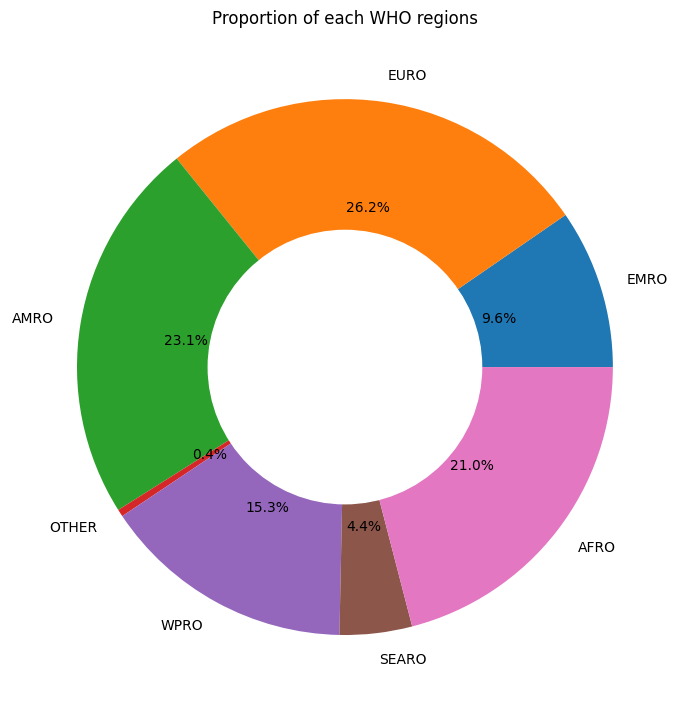

In [ ]:
plt.figure(figsize=(7, 7),dpi=100)
groupby = data.groupBy('WHO_REGION').count()
a=groupby.select('WHO_REGION').rdd.flatMap(lambda x: x).collect()
b=groupby.select('count').rdd.flatMap(lambda x: x).collect()
_, _, autotexts = plt.pie(b,labels = a,autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('black')
circle = plt.Circle( (0,0), 0.51, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.tight_layout()
plt.title("Proportion of each WHO regions")
plt.savefig("1")
plt.show()


Figure shows that EURO region has most share among all other regions of WHO. Their proportion is 26.2% while the proportion of AMRO region is 23.1% which is the second highest.

### Proportion of Data Sources

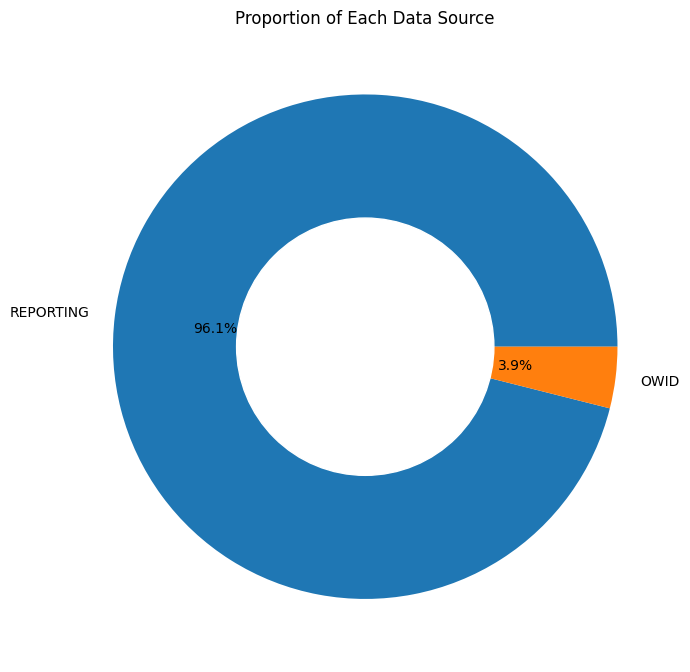

In [ ]:
plt.figure(figsize=(7, 7),dpi=100)
groupby = data.groupBy('DATA_SOURCE').count()
a=groupby.select('DATA_SOURCE').rdd.flatMap(lambda x: x).collect()
b=groupby.select('count').rdd.flatMap(lambda x: x).collect()
_, _, autotexts = plt.pie(b,labels = a,autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('black')
circle = plt.Circle( (0,0), 0.51, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.tight_layout()
plt.title("Proportion of Each Data Source")
plt.savefig("2")

plt.show()

Above figure shows that the major source of data is Reporting. It means that about 95% cames from Reporting while the rest 5% cames from OWID.

### Top 10 Countries with most number of Vaccines

In [ ]:
data_vaccine=data.withColumn('TOTAL_VACCINATIONS',data.TOTAL_VACCINATIONS.cast("float"))

In [ ]:
top10=data_vaccine.sort(desc("TOTAL_VACCINATIONS")).limit(10)

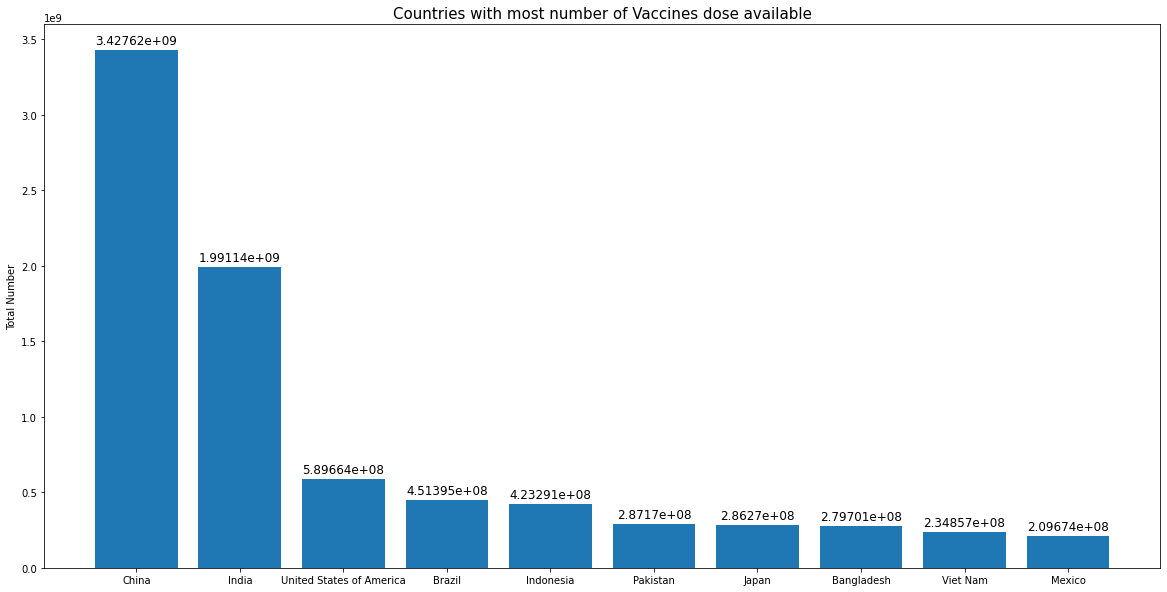

In [ ]:
plt.figure(figsize = [20, 10])
a=top10.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
b=top10.select('TOTAL_VACCINATIONS').rdd.flatMap(lambda x: x).collect()
bar1 = plt.bar(a,b)
plt.bar_label(bar1, padding=3, fontsize=12)
plt.title("Countries with most number of Vaccines dose available",fontsize = 15)
plt.ylabel("Total Number")
plt.savefig("3")
plt.show()

#### 10 Least number of vaccine Countries

In [ ]:
data_vaccine=data_vaccine.na.drop(subset=["TOTAL_VACCINATIONS"])

In [ ]:
Bottom10=data_vaccine.sort(asc("TOTAL_VACCINATIONS")).limit(10)

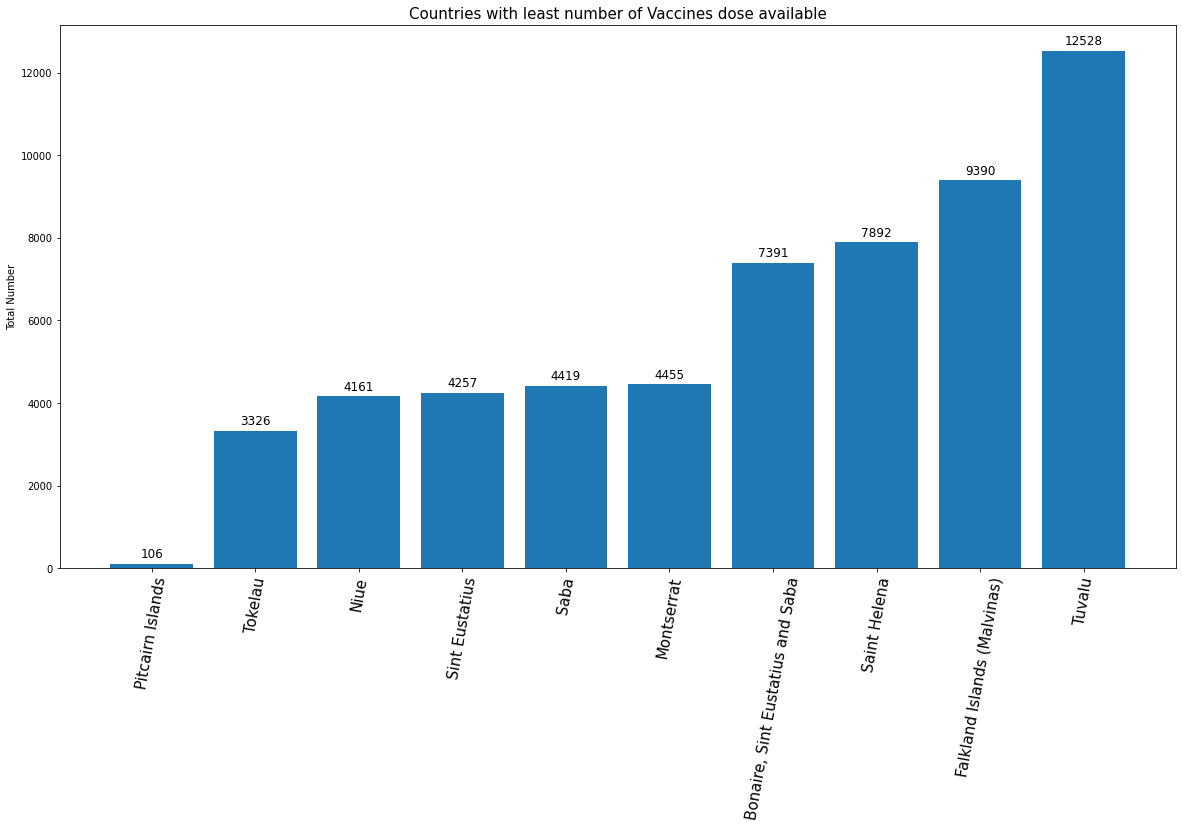

In [ ]:
plt.figure(figsize = [20, 10])
c=Bottom10.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
d=Bottom10.select('TOTAL_VACCINATIONS').rdd.flatMap(lambda x: x).collect()
bar1 = plt.bar(c,d)
plt.bar_label(bar1, padding=3, fontsize=12)
plt.xticks(rotation=80,fontsize = 15)
plt.title("Countries with least number of Vaccines dose available",fontsize = 15)
plt.ylabel("Total Number")
plt.savefig("4")
plt.show()

### Top 20 countries with highest number of vaccination for each 100 people

In [ ]:
data_vaccine_100=data.withColumn('TOTAL_VACCINATIONS_PER100',data.TOTAL_VACCINATIONS_PER100.cast("float"))

In [ ]:
Top20HighVaccine=data_vaccine_100.sort(desc("TOTAL_VACCINATIONS_PER100")).limit(20)

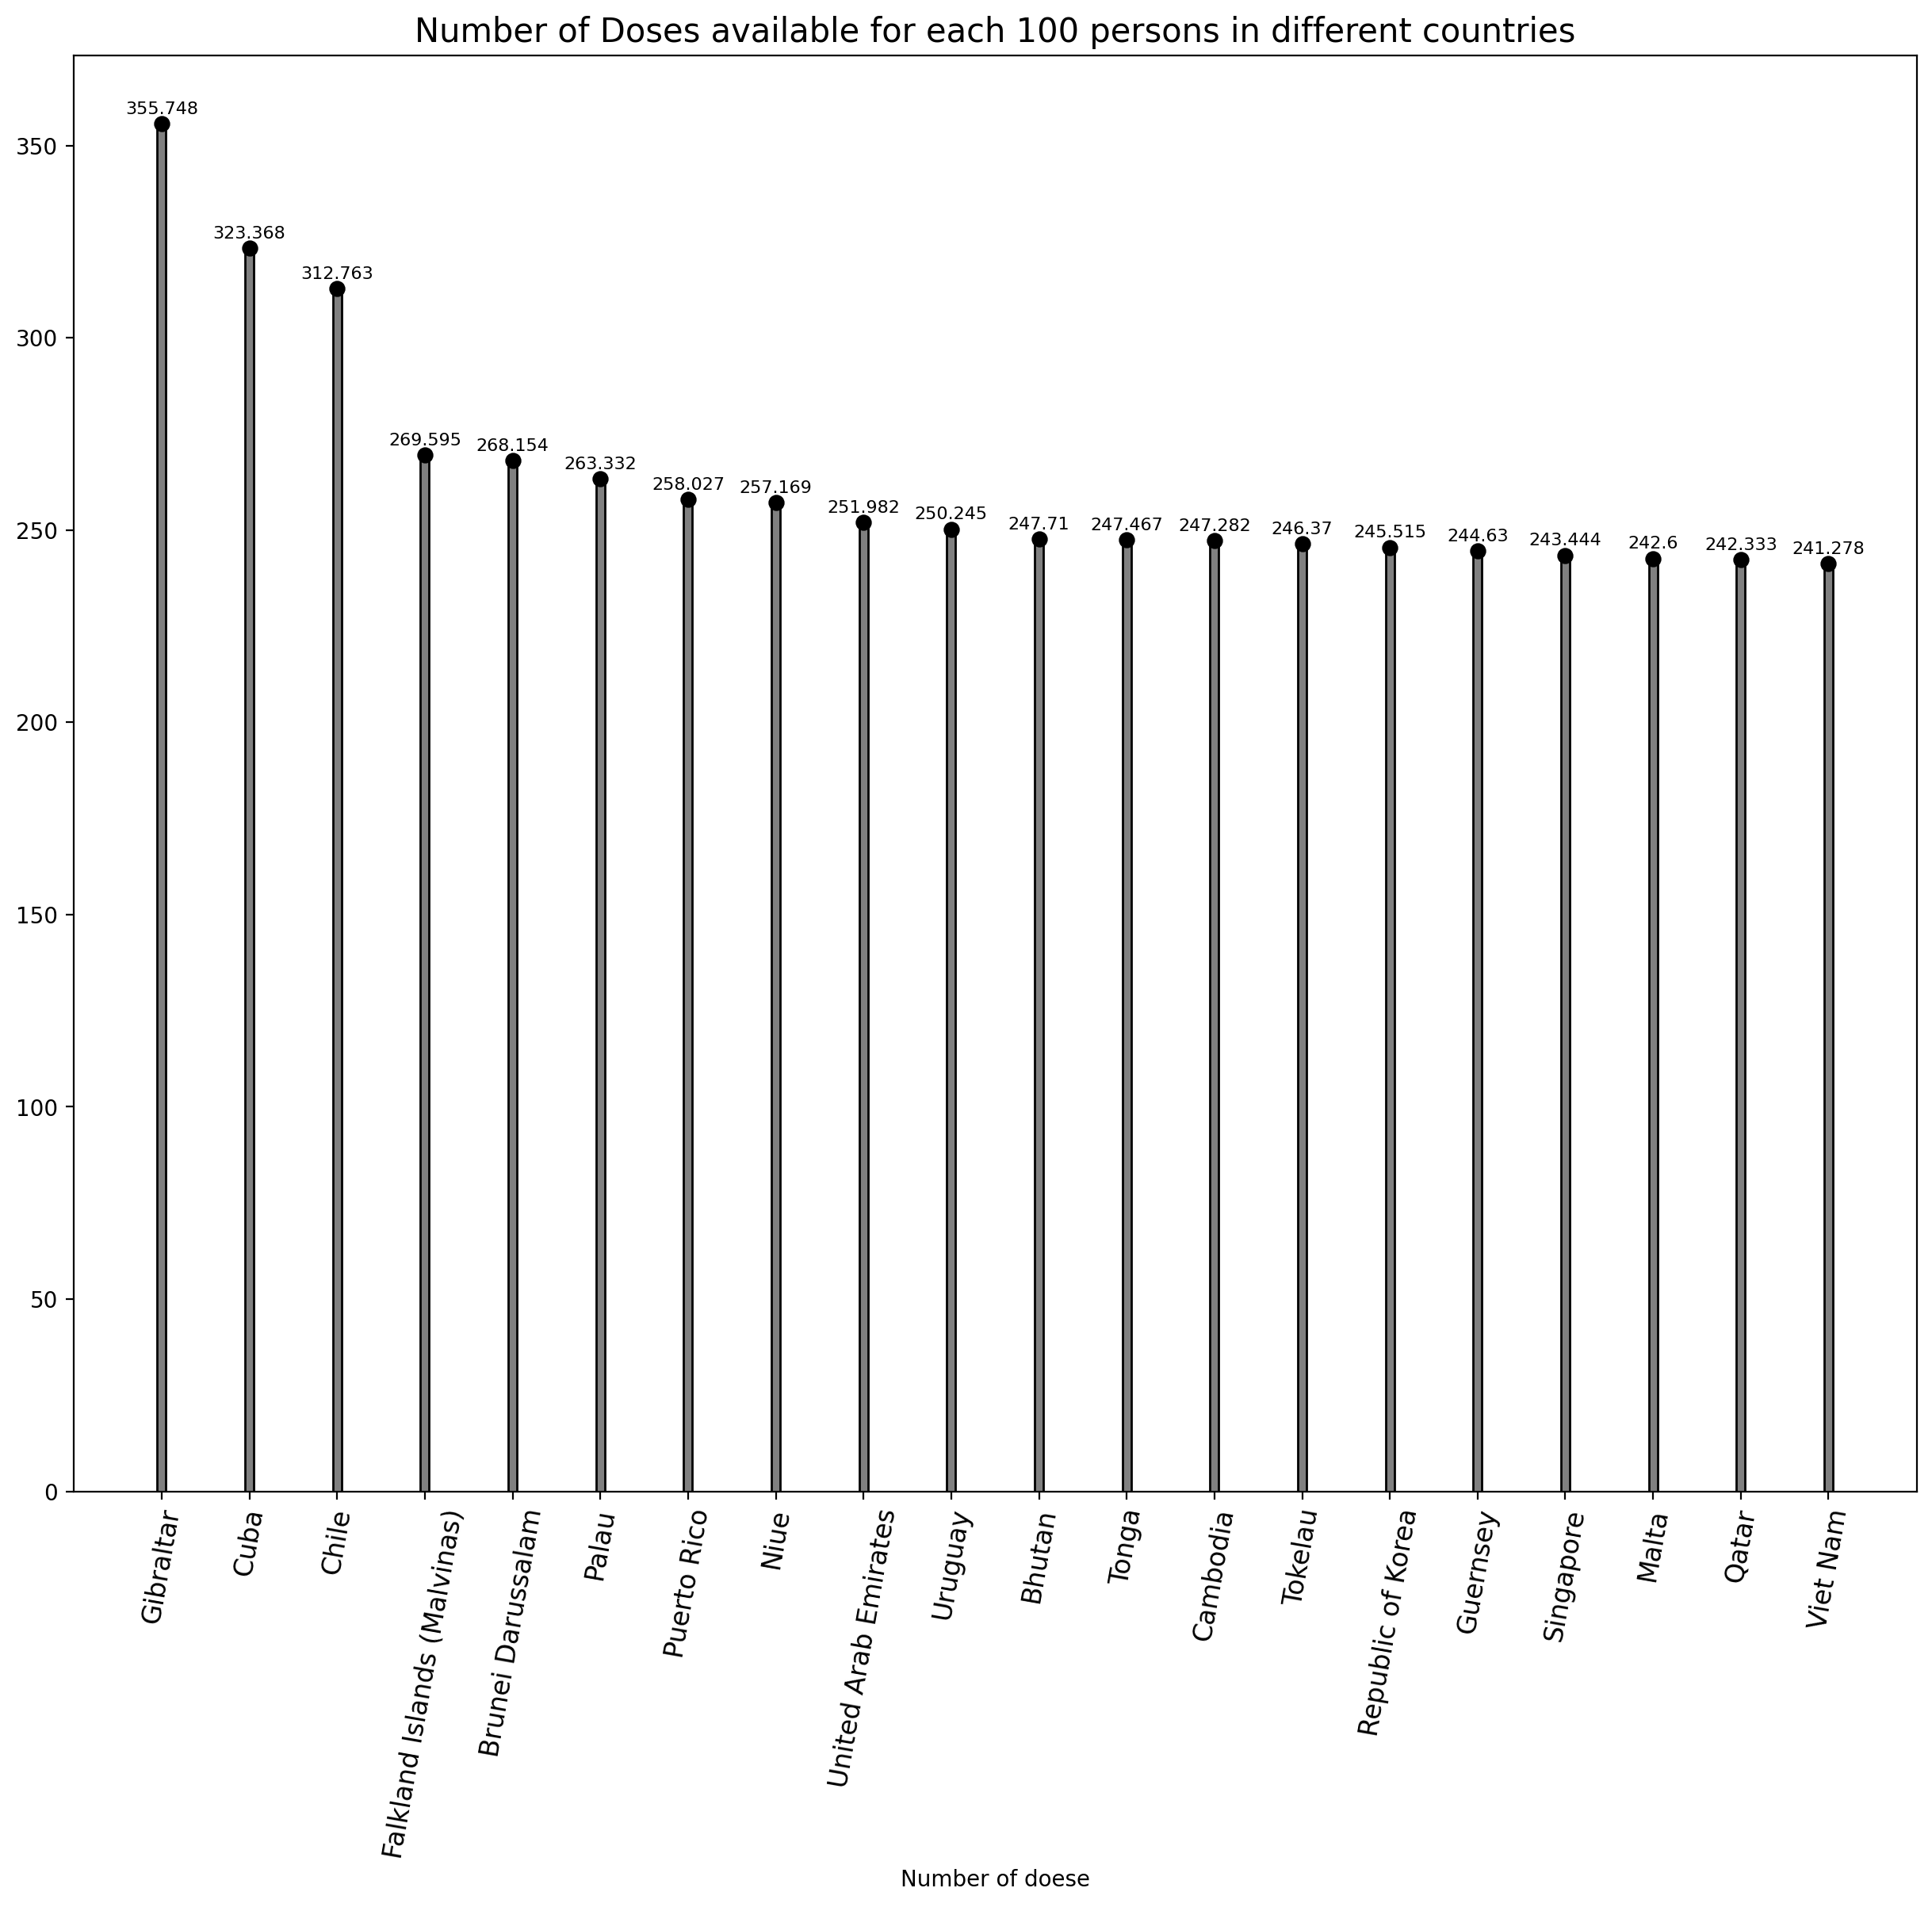

In [ ]:
plt.figure(figsize=(15, 12),dpi=200)
e=Top20HighVaccine.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
f=Top20HighVaccine.select('TOTAL_VACCINATIONS_PER100').rdd.flatMap(lambda x: x).collect()
bar1 = plt.bar(e,f,color = 'gray', edgecolor = 'black', width = 0.1)
plt.scatter(e,f, color = 'black', s=40)
plt.bar_label(bar1, padding=3, fontsize=8)
plt.xticks(rotation=80,fontsize = 12)
plt.title("Number of Doses available for each 100 persons in different countries",fontsize = 15)
plt.xlabel("Number of doese")
plt.savefig("5")
plt.show()

### Top 20 countries with highest percentage of Fully Vaccinated people

In [ ]:
data_vaccine_percentage=data.withColumn('PERSONS_FULLY_VACCINATED_PER100',data.PERSONS_FULLY_VACCINATED_PER100.cast("float"))

In [ ]:
Top20HighVaccinePercentage=data_vaccine_percentage.sort(desc("PERSONS_FULLY_VACCINATED_PER100")).limit(20)

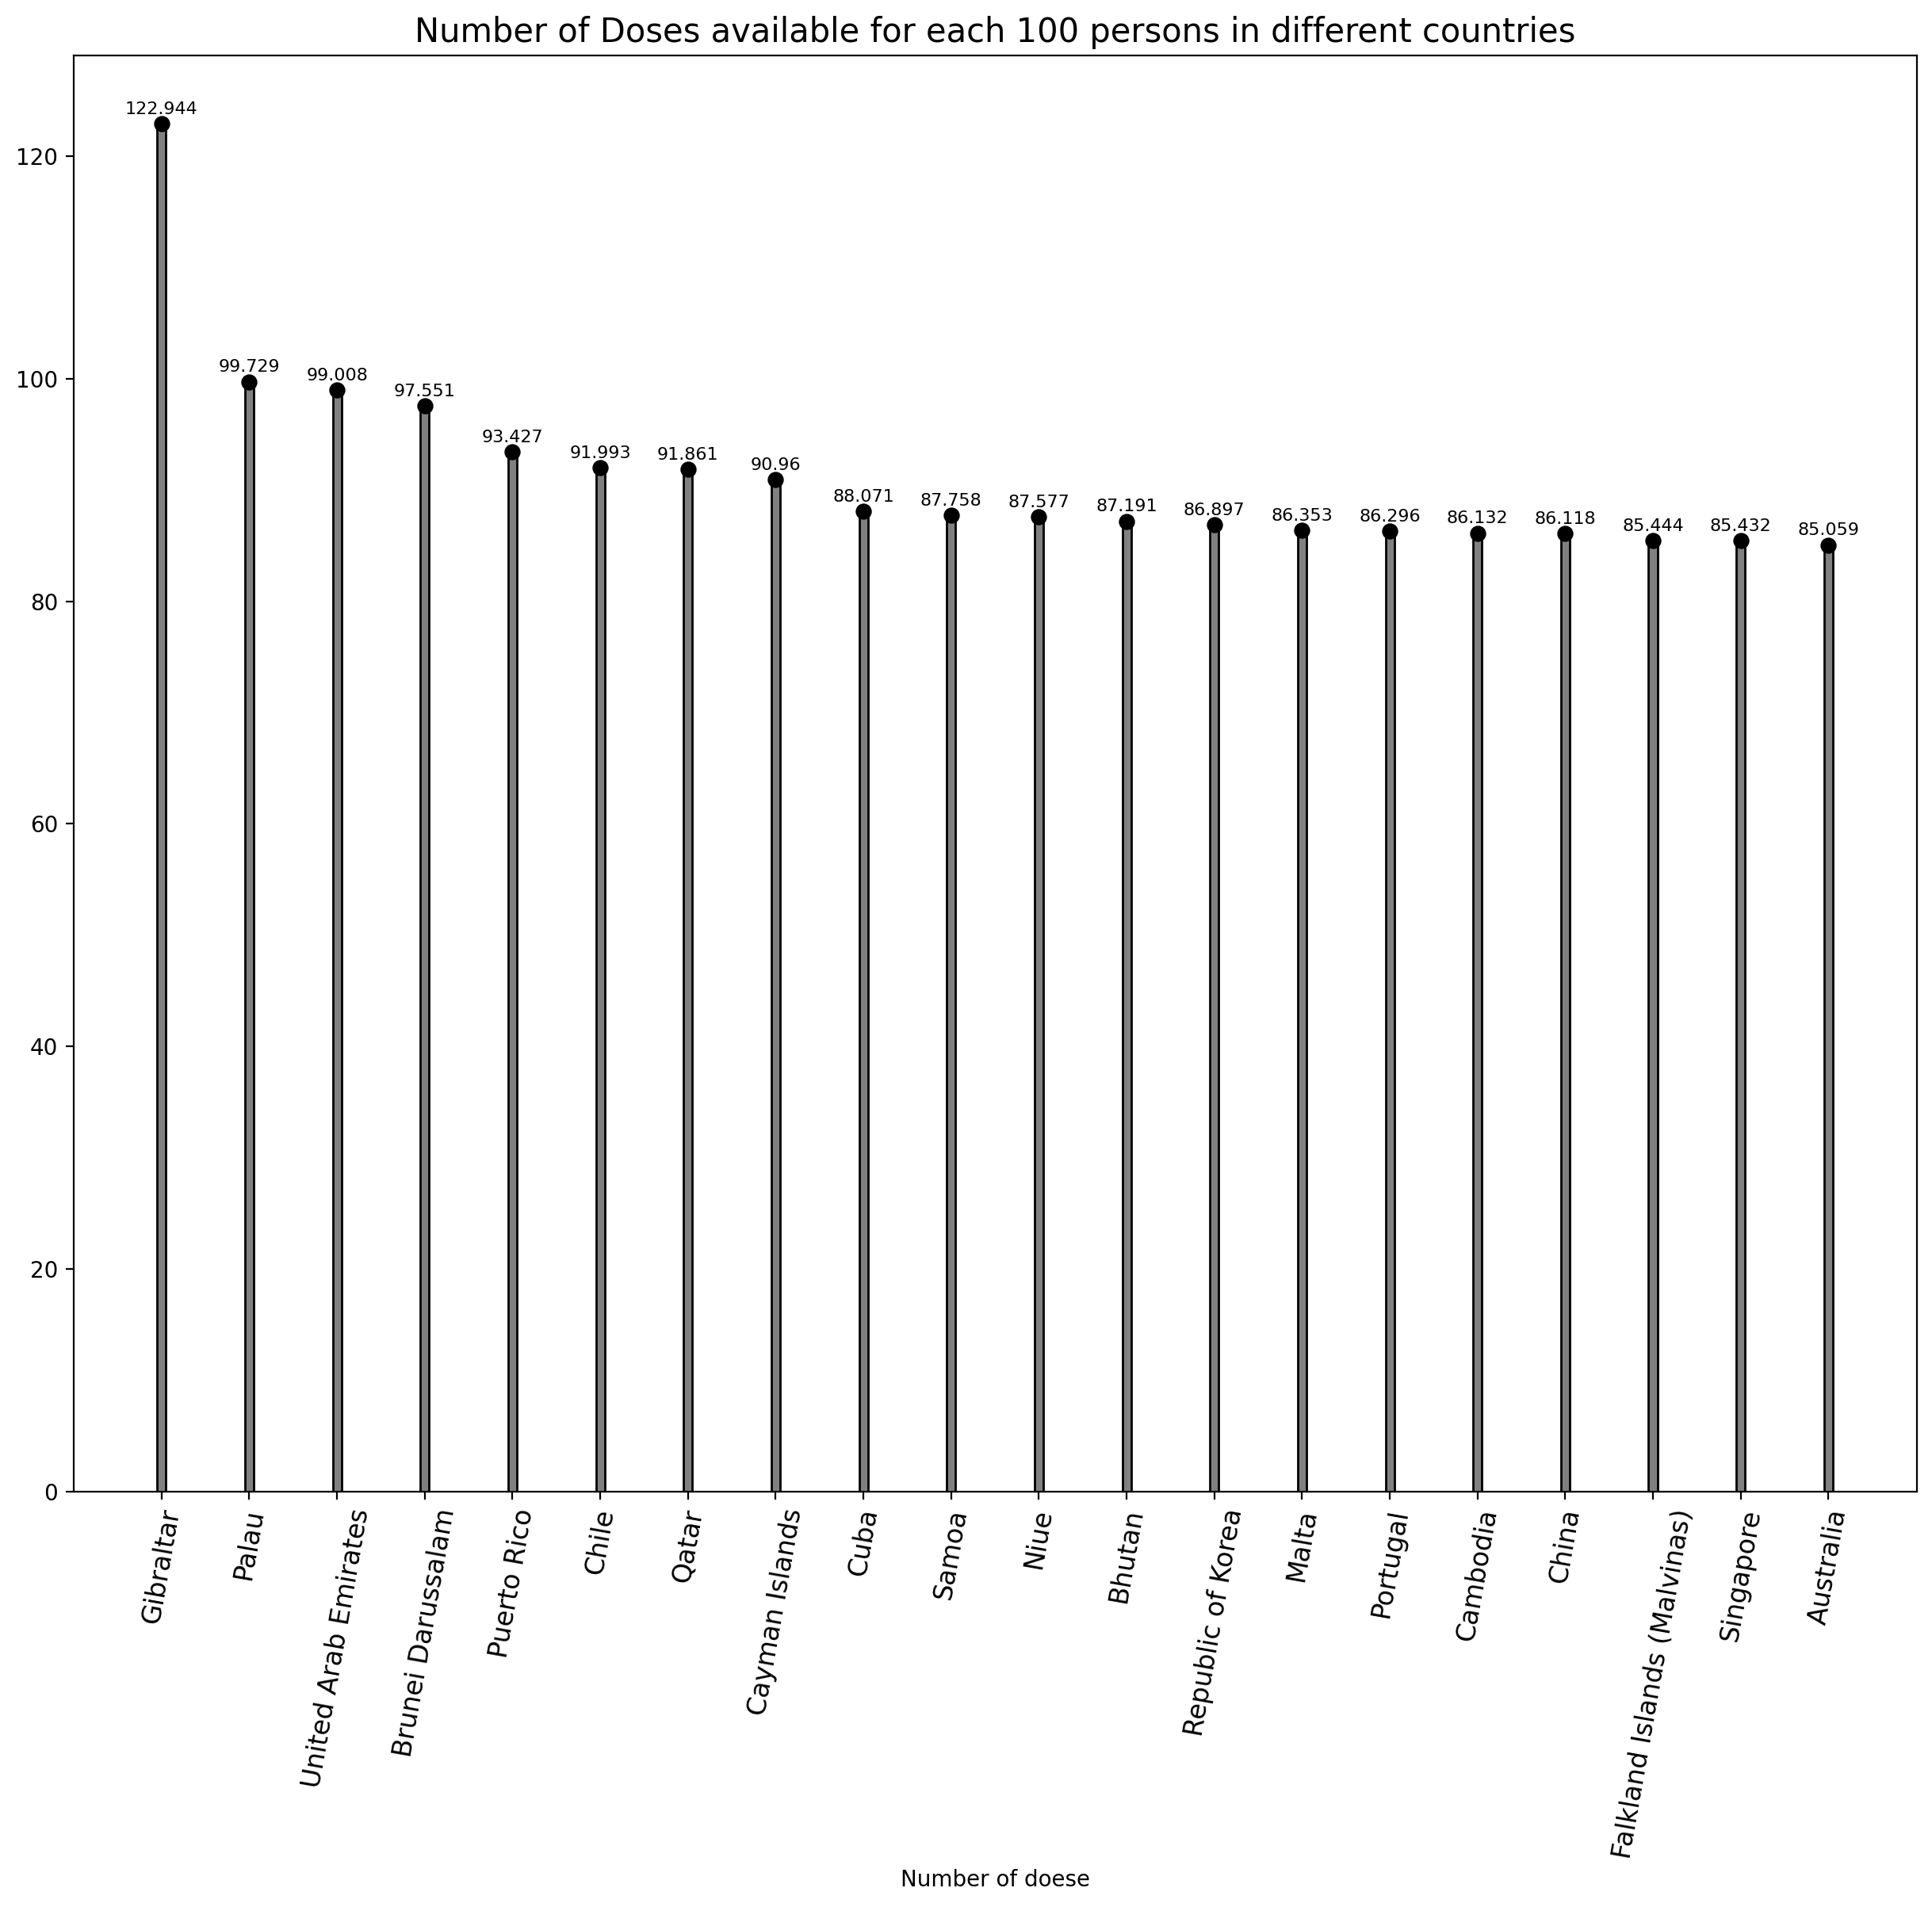

In [ ]:
plt.figure(figsize=(15, 12),dpi=200)
g=Top20HighVaccinePercentage.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
h=Top20HighVaccinePercentage.select('PERSONS_FULLY_VACCINATED_PER100').rdd.flatMap(lambda x: x).collect()
bar1 = plt.bar(g,h,color = 'gray', edgecolor = 'black', width = 0.1)
plt.scatter(g,h, color = 'black', s=40)
plt.bar_label(bar1, padding=3, fontsize=8)
plt.xticks(rotation=80,fontsize = 12)
plt.title("Number of Doses available for each 100 persons in different countries",fontsize = 15)
plt.xlabel("Number of doese")
plt.savefig("6")
plt.show()

### Countries With Earliest Start of Vaccination Process

In [ ]:
df = data.withColumn('FIRST_VACCINE_DATE', to_date("FIRST_VACCINE_DATE"))
df=df.na.drop(subset=["FIRST_VACCINE_DATE"])

In [ ]:
firts10=df.sort(df.FIRST_VACCINE_DATE.asc()).limit(10)

In [ ]:
i=firts10.select('COUNTRY').rdd.flatMap(lambda x: x).collect()

In [ ]:
print("10 Countries start vaccination earlier than others are")
i

10 Countries start vaccination earlier than others are


['China',
 'Bahrain',
 "Lao People's Democratic Republic",
 'Canada',
 'United States of America',
 'Denmark',
 'Israel',
 'Northern Mariana Islands (Commonwealth of the)',
 'American Samoa',
 'Chile']

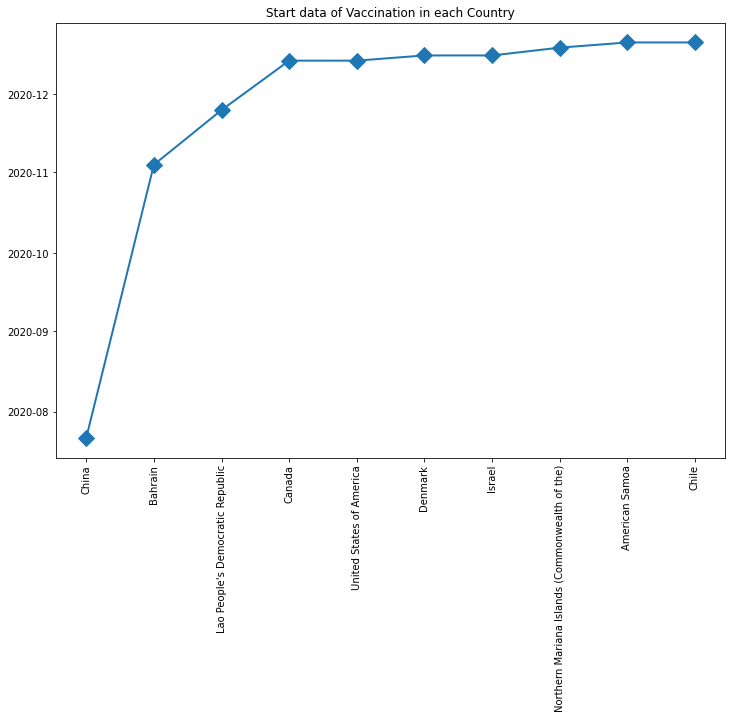

In [ ]:
plt.figure(figsize = [12,8])
i=firts10.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
j=firts10.select('FIRST_VACCINE_DATE').rdd.flatMap(lambda x: x).collect()
plt.plot(i,j,marker='D',linewidth=2, markersize=12)
plt.xticks(rotation = 90)
plt.title("Start data of Vaccination in each Country")
plt.savefig("7")
plt.show()

### Persons Booster Dose for each 100 Persons in Countries with Earliest start of Vaccination program.

In [ ]:
firts10=firts10.withColumn('PERSONS_BOOSTER_ADD_DOSE_PER100',data.PERSONS_BOOSTER_ADD_DOSE_PER100.cast("float"))

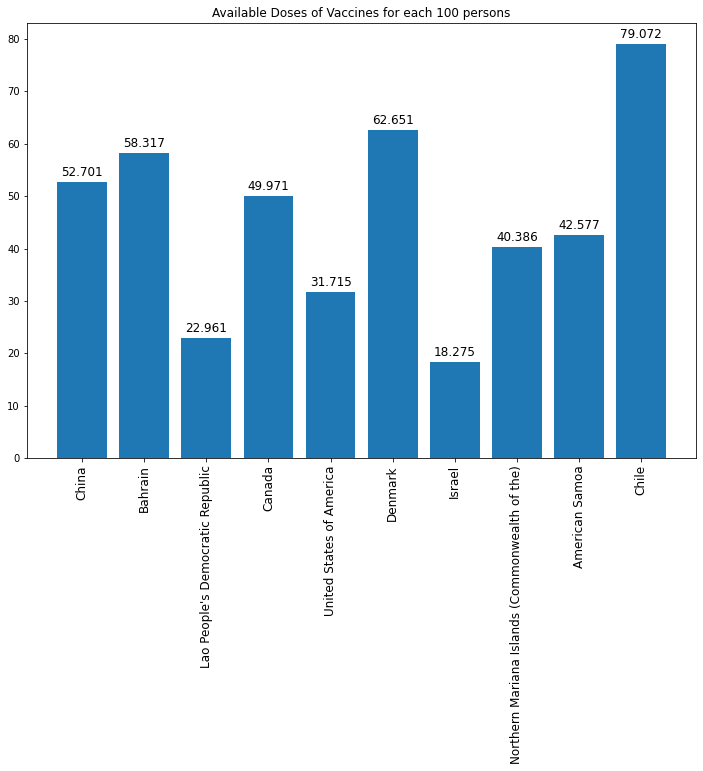

In [ ]:
plt.figure(figsize = [12,8])
k=firts10.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
l=firts10.select('PERSONS_BOOSTER_ADD_DOSE_PER100').rdd.flatMap(lambda x: x).collect()
bar1  = plt.bar(k,l)
plt.bar_label(bar1, padding=3, fontsize=12)
plt.xticks(rotation=90,fontsize = 12)
plt.title("Available Doses of Vaccines for each 100 persons")
plt.savefig("8")
plt.show()

### Which countries used highest number of vaccine types

In [ ]:
Top10MoreNumberOfVaccine=data.withColumn('NUMBER_VACCINES_TYPES_USED',data.NUMBER_VACCINES_TYPES_USED.cast("int"))

In [ ]:
top10Vaccine=Top10MoreNumberOfVaccine.sort(desc("NUMBER_VACCINES_TYPES_USED")).limit(20)

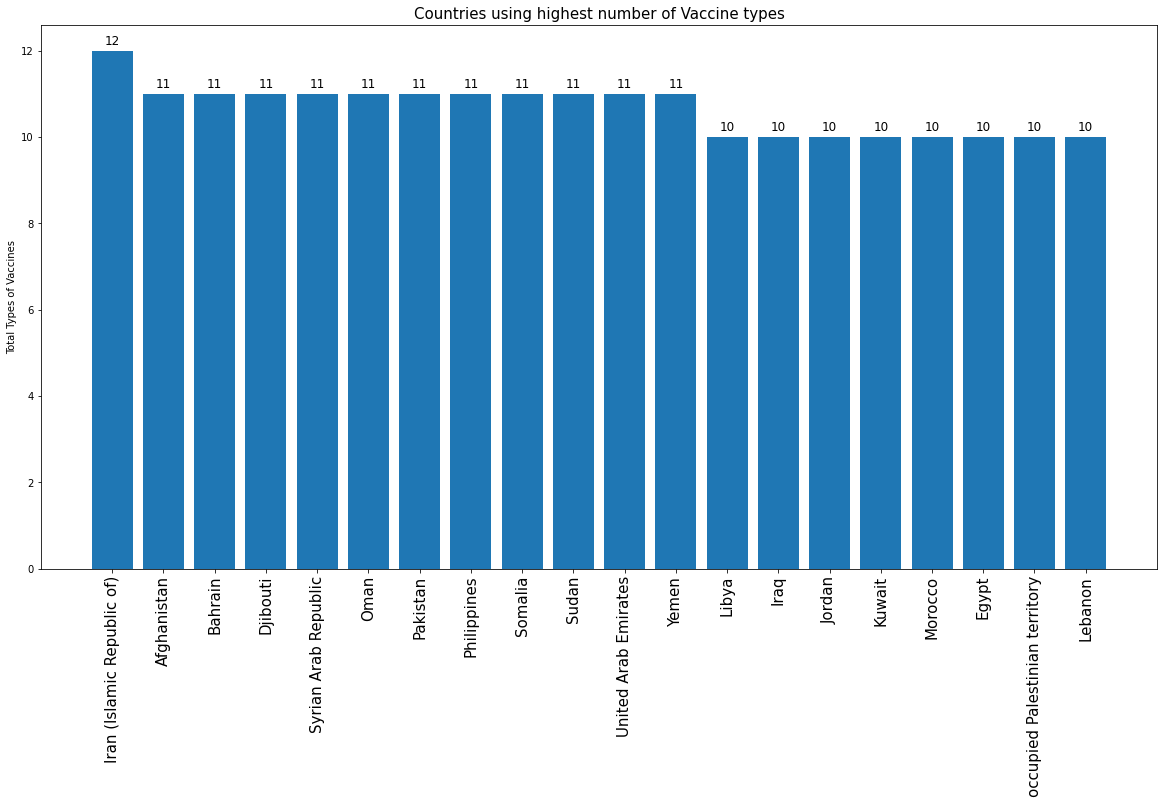

In [ ]:
plt.figure(figsize = [20, 10])
x=top10Vaccine.select('COUNTRY').rdd.flatMap(lambda x: x).collect()
y=top10Vaccine.select('NUMBER_VACCINES_TYPES_USED').rdd.flatMap(lambda x: x).collect()
bar1 = plt.bar(x,y)
plt.bar_label(bar1, padding=3, fontsize=12)
plt.xticks(rotation=90,fontsize = 15)
plt.title("Countries using highest number of Vaccine types",fontsize = 15)
plt.ylabel("Total Types of Vaccines")
plt.savefig("9")

plt.show()